# TensorTrade Visualization Chart Demo

## Setup Data Fetching

In [1]:
import pandas as pd

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)
    df.set_index("date", inplace=True)
    return df

In [2]:
df = load_csv('Coinbase_BTCUSD_1h.csv')
df.head(3)

,open,high,low,close,volume
date,,,,,
2019-10-17 09-AM,8051.00,8056.83,8021.23,8035.88,492394.56
2019-10-17 08-AM,7975.89,8070.00,7975.89,8051.00,2971610.86
2019-10-17 07-AM,7964.62,7987.82,7964.61,7975.89,970521.83


## Data Preparation
### Create the dataset features

In [4]:
import ta

from tensortrade.data import DataFeed, Module

dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
dataset.head(3)

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
date,,,,,,,,,,,,,,,,,,,,,
2019-10-17 09-AM,8051.00,8056.83,8021.23,8035.88,492394.56,-8.713724e+04,492394.56,-0.176966,0.000000e+00,0.000000,...,50.0,41.151685,41.151685,-58.848315,0.0,8035.88,0.0,11.938592,0.000000,0.000000
2019-10-17 08-AM,7975.89,8070.00,7975.89,8051.00,2971610.86,1.684588e+06,3464005.42,0.486312,4.493076e+07,-50940.699214,...,50.0,79.810860,60.481273,-20.189140,0.0,8051.00,0.0,0.188156,0.187979,0.188156
2019-10-17 07-AM,7964.62,7987.82,7964.61,7975.89,970521.83,1.657409e+06,2493483.59,0.373751,2.809838e+07,-111754.652649,...,50.0,10.703103,43.888549,-89.296897,0.0,7975.89,0.0,-0.932928,-0.937307,-0.746527


### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and the cleaning the dataset to ensure a 1-to-1 mapping between the historical prices data and the dataset.

In [5]:
price_history = dataset[['open', 'high', 'low', 'close', 'volume']]
price_history.reset_index(inplace=True)  # the index will be used as the chart training steps
display(price_history.head(3))

dataset.drop(columns=['open', 'high', 'low', 'close', 'volume'], inplace=True)

,date,open,high,low,close,volume
0,2019-10-17 09-AM,8051.00,8056.83,8021.23,8035.88,492394.56
1,2019-10-17 08-AM,7975.89,8070.00,7975.89,8051.00,2971610.86
2,2019-10-17 07-AM,7964.62,7987.82,7964.61,7975.89,970521.83


## Setup Trading Environment

In [6]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, DataFeed, Module
from tensortrade.instruments import USD, BTC
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.environments import TradingEnvironment

coinbase = Exchange("coinbase", service=execute_order)(
    Stream("USD-BTC", price_history['close'].tolist())
)

portfolio = Portfolio(USD, [
    Wallet(coinbase, 10000 * USD),
    Wallet(coinbase, 10 * BTC),
])

with Module("coinbase") as coinbase_ns:
    nodes = [Stream(name, dataset[name].tolist()) for name in dataset.columns]

feed = DataFeed([coinbase_ns])
display(feed.next())
feed.reset()

{'coinbase:/volume_adi': -87137.23955055085,
 'coinbase:/volume_obv': 492394.56,
 'coinbase:/volume_cmf': -0.17696629213480922,
 'coinbase:/volume_fi': 0.0,
 'coinbase:/volume_em': 0.0,
 'coinbase:/volume_sma_em': 0.0,
 'coinbase:/volume_vpt': 57684.90807817994,
 'coinbase:/volume_nvi': 1000.0,
 'coinbase:/volatility_atr': 0.0,
 'coinbase:/volatility_bbm': 8035.88,
 'coinbase:/volatility_bbh': 8035.88,
 'coinbase:/volatility_bbl': 8035.88,
 'coinbase:/volatility_bbw': 0.0,
 'coinbase:/volatility_bbhi': 0.0,
 'coinbase:/volatility_bbli': 0.0,
 'coinbase:/volatility_kcc': 8037.98,
 'coinbase:/volatility_kch': 8037.98,
 'coinbase:/volatility_kcl': 8002.38,
 'coinbase:/volatility_kchi': 0.0,
 'coinbase:/volatility_kcli': 0.0,
 'coinbase:/volatility_dcl': 8035.88,
 'coinbase:/volatility_dch': 8035.88,
 'coinbase:/volatility_dchi': 1.0,
 'coinbase:/volatility_dcli': 1.0,
 'coinbase:/trend_macd': 0.0,
 'coinbase:/trend_macd_signal': 0.0,
 'coinbase:/trend_macd_diff': 0.0,
 'coinbase:/trend_em

### Data Feed Observation Sample

In [7]:
env = TradingEnvironment(
    feed=feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='risk-adjusted',
    window_size=20,
    price_history=price_history,
    chart_height=800
)
display(env.feed.next())
env.feed.reset()

{'coinbase:/volume_adi': -87137.23955055085,
 'coinbase:/volume_obv': 492394.56,
 'coinbase:/volume_cmf': -0.17696629213480922,
 'coinbase:/volume_fi': 0.0,
 'coinbase:/volume_em': 0.0,
 'coinbase:/volume_sma_em': 0.0,
 'coinbase:/volume_vpt': 57684.90807817994,
 'coinbase:/volume_nvi': 1000.0,
 'coinbase:/volatility_atr': 0.0,
 'coinbase:/volatility_bbm': 8035.88,
 'coinbase:/volatility_bbh': 8035.88,
 'coinbase:/volatility_bbl': 8035.88,
 'coinbase:/volatility_bbw': 0.0,
 'coinbase:/volatility_bbhi': 0.0,
 'coinbase:/volatility_bbli': 0.0,
 'coinbase:/volatility_kcc': 8037.98,
 'coinbase:/volatility_kch': 8037.98,
 'coinbase:/volatility_kcl': 8002.38,
 'coinbase:/volatility_kchi': 0.0,
 'coinbase:/volatility_kcli': 0.0,
 'coinbase:/volatility_dcl': 8035.88,
 'coinbase:/volatility_dch': 8035.88,
 'coinbase:/volatility_dchi': 1.0,
 'coinbase:/volatility_dcli': 1.0,
 'coinbase:/trend_macd': 0.0,
 'coinbase:/trend_macd_signal': 0.0,
 'coinbase:/trend_macd_diff': 0.0,
 'coinbase:/trend_em

## Setup and Train DQN Agent

In [8]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)
agent.train(n_steps=200, render_interval=5)

====      AGENT ID: 1b459294-ddce-4ac3-a48e-27df414d3c3e      ====


FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

====      EPISODE ID (1/2147483647): dc4a4b8e-6b68-470f-a546-316d5764bbd5      ====


-0.06941785956092401

## Direct Performance and Net Worth Plotting
Alternatively, the final performance and net worth can be displayed using pandas via matplotlib.

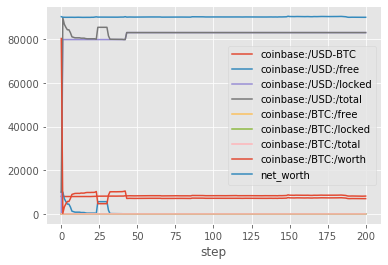

In [9]:
%matplotlib inline

portfolio.performance.plot()

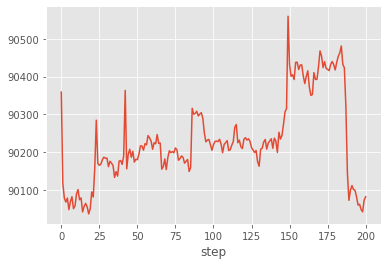

In [10]:
portfolio.performance.net_worth.plot()